In [47]:
import time
import torch
import sys
import os
import matplotlib.pyplot as plt

# Add project root to PYTHONPATH
sys.path.append('/home/vkapil/scratch/nl/torch-nlpp')

from ase import Atoms
from neighbourlist import NeighbourList
from vesin import ase_neighbor_list
from vesin import NeighborList as NeighbourList_vesin
from torch_nl import compute_neighborlist, ase2data

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update({
    'lines.markersize': 4,
    'lines.linewidth': 1.5,  # Increased from 1 to 1.5
    'font.size': 8,
    'axes.labelsize': 8,
    'axes.titlesize': 8,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 8,
    'figure.titlesize': 8,
    'axes.grid': True,
    'grid.linewidth': 0.5,
    'grid.alpha': 1.0,
})

colors = sns.color_palette("deep")

In [42]:
def time_fn(fn, n_tries=10, sync_cuda=False):
    # warmup
    fn()
    
    if sync_cuda and torch.cuda.is_available():
        torch.cuda.synchronize()

    start = time.perf_counter()
    for _ in range(n_tries):
        fn()
    if sync_cuda and torch.cuda.is_available():
        torch.cuda.synchronize()
    return (time.perf_counter() - start) / n_tries * 1000.0  # ms

In [43]:
cell = [
    [2.460394, 0.0, 0.0],
    [-1.26336, 2.044166, 0.0],
    [-0.139209, -0.407369, 6.809714],
]

positions = [
    [-0.03480225, -0.10184225, 1.70242850],
    [-0.10440675, -0.30552675, 5.10728550],
    [-0.05691216,  1.26093576, 1.70242850],
    [ 1.11473716,  0.37586124, 5.10728550],
]

base = Atoms(
    symbols="CCCC",
    positions=positions,
    cell=cell,
    pbc=True,
) * (4,4,2)


In [44]:

number_of_structures = [1, 2, 4, 8, 16, 32, 64, 128]     
radii = [3.0, 4.5, 6.0]
n_tries = 1

device = "cuda:0" 

In [45]:
number_of_structures = [1, 2, 4, 8, 16, 32, 64, 128]

results = {}   # radius → n_struct → timings dict
base_natoms = len(base)

for radius in radii:
    print("\n" + "=" * 80)
    print(f"radius = {radius}")
    print("=" * 80)

    results[radius] = {}

    for n_struct in number_of_structures:

        # Create n_struct independent copies of the same base structure
        configs = [base.copy() for _ in range(n_struct)]
        total_atoms = n_struct * base_natoms

        print(f"\nNumber of structures: {n_struct}  →  total_atoms = {total_atoms}")

        # IMPORTANT: key by n_struct (for plotting on x-axis)
        results[radius][n_struct] = {}

        # --- VK NeighbourList (O(N^2), no compile) ---
        nl = NeighbourList(
            list_of_configurations=configs,
            radius=radius,
            batch_size=n_struct,
            device=device,
        )
        nl.load_data()

        def vk_nl_no_compile():
            _ = nl.calculate_neighbourlist(use_torch_compile=False)

        t_vk_no_compile = time_fn(vk_nl_no_compile, n_tries=n_tries, sync_cuda=True)
        results[radius][n_struct]["vk"] = t_vk_no_compile

        # --- VK NeighbourList (O(N^2), compile=True) ---
        def vk_nl_compile():
            _ = nl.calculate_neighbourlist(use_torch_compile=True)

        t_vk_compile = time_fn(vk_nl_compile, n_tries=n_tries, sync_cuda=True)
        results[radius][n_struct]["vk_compile"] = t_vk_compile

        # --- ASE neighbour list (O(N)) ---
        def ase_nl():
            for atoms in configs:
                i, j, S, d = ase_neighbor_list("ijSd", atoms, cutoff=radius)

        t_ase = time_fn(ase_nl, n_tries=n_tries, sync_cuda=False)
        results[radius][n_struct]["ase"] = t_ase

        # --- vesin neighbour list (O(N)) ---
        def vesin_nl():
            for atoms in configs:
                calculator = NeighbourList_vesin(cutoff=radius, full_list=True)
                i, j, S, d = calculator.compute(
                    points=atoms.positions,
                    box=atoms.cell,
                    periodic=True,
                    quantities="ijSd",
                )

        t_vesin = time_fn(vesin_nl, n_tries=n_tries, sync_cuda=False)
        results[radius][n_struct]["vesin"] = t_vesin

        # --- torch-nl O(N), fully batched over all configs ---
        pos, cell_t, pbc, batch, _ = ase2data(configs)

        def torch_nl_n1():
            compute_neighborlist(radius, pos, cell_t, pbc, batch, False)

        t_torch_n1 = time_fn(torch_nl_n1, n_tries=n_tries, sync_cuda=True)
        results[radius][n_struct]["torch_n1"] = t_torch_n1

        # summary
        print(f"  VK O(N^2) (no compile)     : {t_vk_no_compile:8.3f} ms")
        print(f"  VK O(N^2) (compile=True)   : {t_vk_compile:8.3f} ms")
        print(f"  ASE O(N)                   : {t_ase:8.3f} ms")
        print(f"  vesin O(N)                 : {t_vesin:8.3f} ms")
        print(f"  torch-nl O(N)              : {t_torch_n1:8.3f} ms")



radius = 3.0

Number of structures: 1  →  total_atoms = 128
  VK O(N^2) (no compile)     :    0.886 ms
  VK O(N^2) (compile=True)   :    1.302 ms
  ASE O(N)                   :    0.348 ms
  vesin O(N)                 :    0.222 ms
  torch-nl O(N)              :    4.832 ms

Number of structures: 2  →  total_atoms = 256
  VK O(N^2) (no compile)     :    0.931 ms
  VK O(N^2) (compile=True)   :    0.941 ms
  ASE O(N)                   :    0.556 ms
  vesin O(N)                 :    0.425 ms
  torch-nl O(N)              :    8.395 ms

Number of structures: 4  →  total_atoms = 512
  VK O(N^2) (no compile)     :    1.149 ms
  VK O(N^2) (compile=True)   :    1.009 ms
  ASE O(N)                   :    1.020 ms
  vesin O(N)                 :    0.706 ms
  torch-nl O(N)              :   13.267 ms

Number of structures: 8  →  total_atoms = 1024
  VK O(N^2) (no compile)     :    1.595 ms
  VK O(N^2) (compile=True)   :    1.401 ms
  ASE O(N)                   :    2.126 ms
  vesin O(N)           

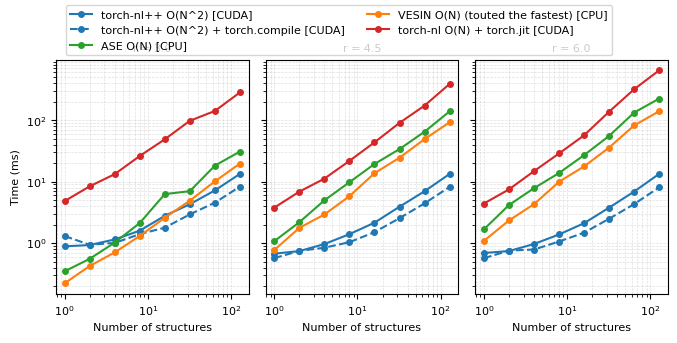

In [46]:
methods = ["vk", "vk_compile", "ase", "vesin", "torch_n1"]

labels = {
    "vk":         "torch-nl++ O(N^2) [CUDA]",
    "vk_compile": "torch-nl++ O(N^2) + torch.compile [CUDA]",
    "ase":        "ASE O(N) [CPU]",
    "vesin":      "VESIN O(N) (touted the fastest) [CPU]",
    "torch_n1":   "torch-nl O(N) + torch.jit [CUDA]",
}

# Fewer colors: one per method family (vk + vk_compile share a color)
colors = {
    "vk":       "tab:blue",
    "ase":      "tab:green",
    "vesin":    "tab:orange",
    "torch_n1": "tab:red",
}

radii_list = list(results.keys())
num_panels = len(radii_list)

fig, axes = plt.subplots(
    1,
    num_panels,
    sharex=True,
    sharey=True,
    figsize=(3.41 * 2, 3.41),
)

if num_panels == 1:
    axes = [axes]

for ax, radius in zip(axes, radii_list):

    # x-axis = number of structures
    n_struct_list = sorted(results[radius].keys())

    for method in methods:
        times = [results[radius][n][method] for n in n_struct_list]

        # Color by family: vk + vk_compile -> "vk"
        if method.startswith("vk"):
            color_key = "vk"
        else:
            color_key = method

        color = colors[color_key]

        # Dashed if compile, solid otherwise
        linestyle = "--" if "compile" in method else "-"

        ax.plot(
            n_struct_list,
            times,
            marker="o",
            linestyle=linestyle,
            color=color,
            label=labels[method],
        )

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_title(f"r = {radius}")
    ax.grid(True, which="both", ls="--", alpha=0.4)

for ax in axes:
    ax.set_xlabel("Number of structures")
axes[0].set_ylabel("Time (ms)")

handles, legend_labels = axes[0].get_legend_handles_labels()
fig.legend(handles, legend_labels, loc="upper center", ncol=len(methods) // 2)

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()